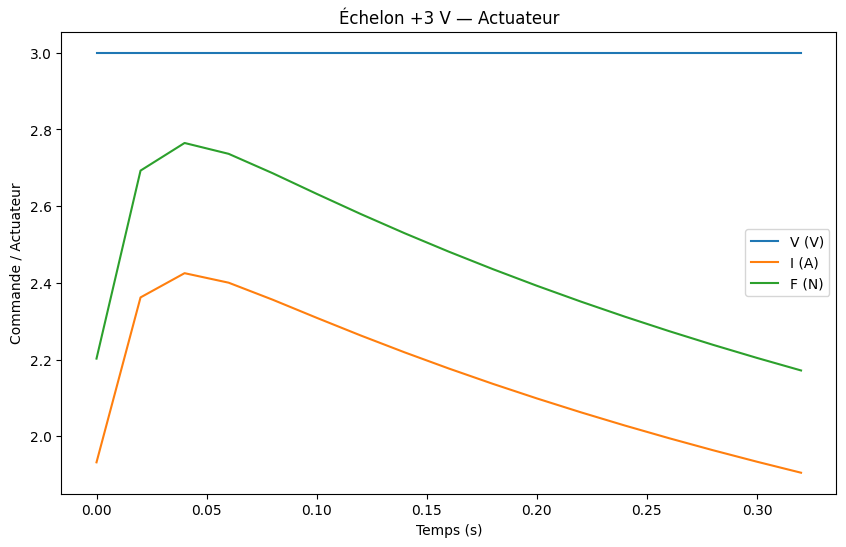

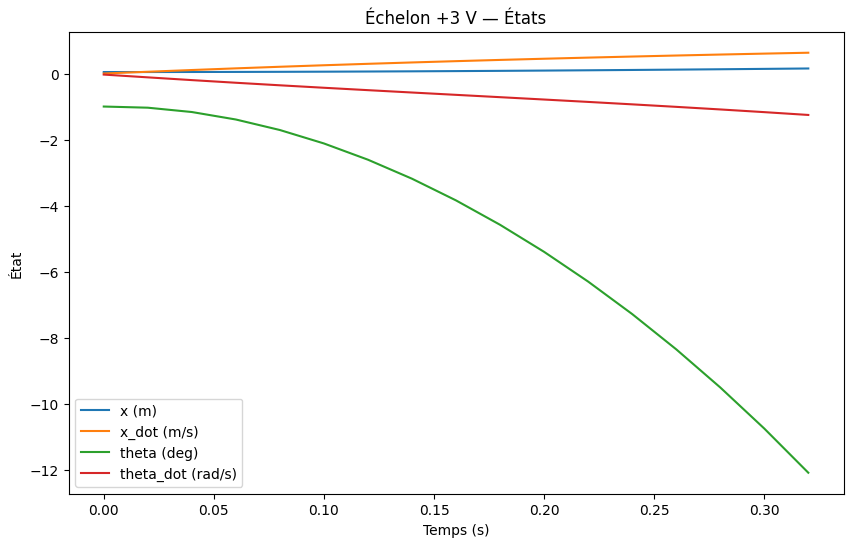

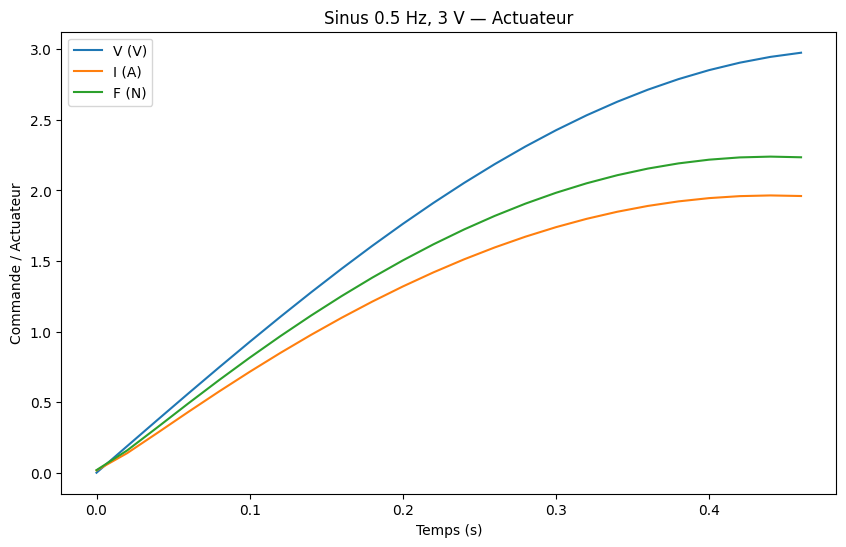

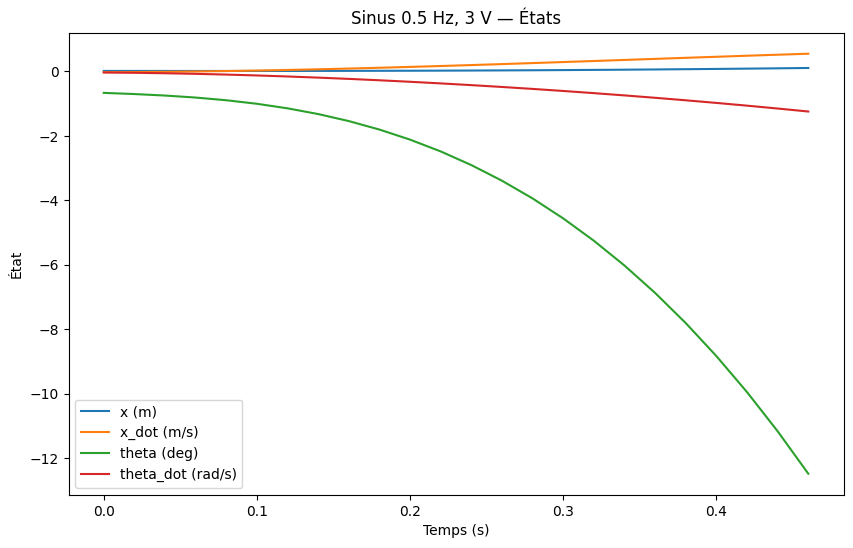

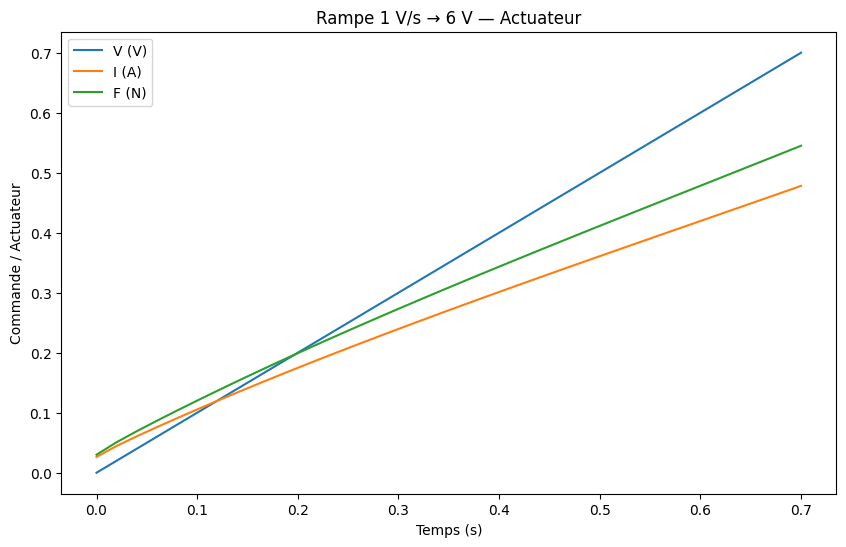

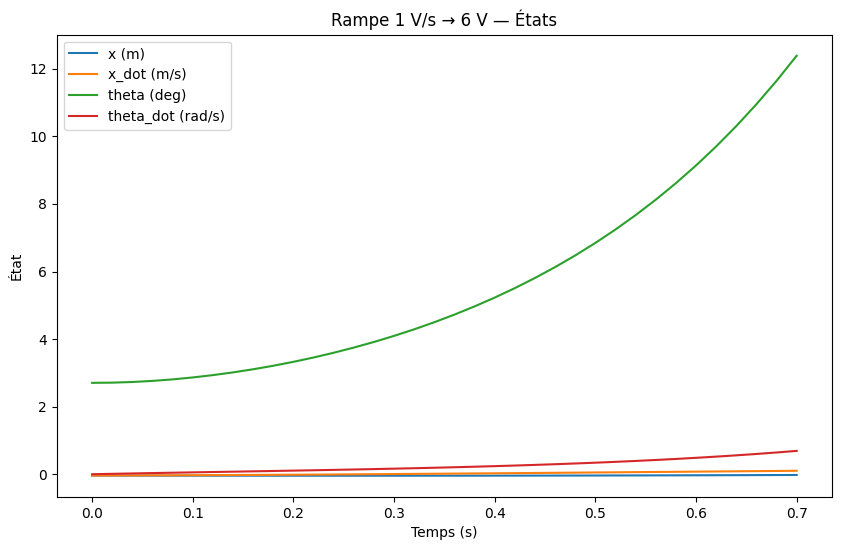

Using cpu device
Logging to ./tb_sac\SAC_24


C:\Users\Bertrand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag
es\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

-----------------------------
| time/              |      |
|    episodes        | 4    |
|    fps             | 1065 |
|    time_elapsed    | 0    |
|    total_timesteps | 194  |
-----------------------------
-----------------------------
| time/              |      |
|    episodes        | 8    |
|    fps             | 1322 |
|    time_elapsed    | 0    |
|    total_timesteps | 418  |
-----------------------------
-----------------------------
| time/              |      |
|    episodes        | 12   |
|    fps             | 1409 |
|    time_elapsed    | 0    |
|    total_timesteps | 561  |
-----------------------------
-----------------------------
| time/              |      |
|    episodes        | 16   |
|    fps             | 1438 |
|    time_elapsed    | 0    |
|    total_timesteps | 672  |
-----------------------------
-----------------------------
| time/              |      |
|    episodes        | 20   |
|    fps             | 1483 |
|    time_elapsed    | 0    |
|    total

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
# =============================================================================
#  CartPole + Moteur CC + Frottements + SAC (continuous control) — v2
#  ——— reboot propre avec shaping léger + sous-pas moteur + VecNormalize ———
#
#  ✅ Objectif
#     Entraîner un agent SAC à stabiliser un pendule inversé CartPole
#     avec un actionneur réaliste (moteur CC R–L + fcem) et frottements.
#
#  🧩 Nouveautés par rapport à v1
#     1) MotorWrapper avec sous-intégration (n_substeps=4) → phase ↓, stabilité ↑
#     2) RewardShapingWrapper (léger) : r = 1 − wθ θ² − wx x² − wV V² − wΔV (ΔV)²
#        → commande moins “bang-bang”, drift de x limité
#     3) VecNormalize (SB3) : normalise les observations (norm_reward=False)
#        → apprentissage plus stable, stats sauvegardées/rechargées
#
#  🛠 Dépendances
#     pip install "gymnasium[classic-control]" stable-baselines3 matplotlib numpy
#     (optionnel rendu fenêtré) pip install pygame
#
#  ▶️ Usage rapide
#     - Lancer ce fichier pour exécuter les tests unitaires (open loop) puis l’entraînement.
#     - Les artefacts sont écrits dans ./checkpoints :
#           sac_cartpole_motor.zip         (modèle)
#           vecnorm_stats.pkl              (statistiques VecNormalize)
#
#  🛰 Notes
#     - Le shaping est activé en entraînement, désactivé en évaluation pour
#       mesurer la “survie” standard CartPole.
#     - L’évaluation recharge les stats de normalisation pour être cohérente
#       avec l’entraînement.
# =============================================================================

from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Callable, Tuple, Optional, Dict, Any, List

import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
import matplotlib.pyplot as plt

# =========================
# Modèle moteur CC minimal
# =========================
@dataclass
class DCMotorSimple:
    R: float = 1.0         # Ohm
    L: float = 0.01        # H
    Ke: float = 0.05       # V/(rad/s)
    Kt: float = 0.05       # N·m/A
    Imax: float = 10.0     # A
    eta: float = 0.95      # rendement méca
    gear: float = 1.0      # rapport de réduction (ω_moteur = gear * v/r)
    r_wheel: float = 0.05  # m (rayon équivalent -> force = T/r)
    i: float = 0.0         # A (état interne)

    def reset(self):
        self.i = 0.0

    def step(self, V: float, v_cart: float, dt: float) -> Tuple[float, float]:
        """
        Intègre le courant et renvoie (force_N, courant_A)
        Hypothèse : ω_moteur ≈ gear * v_cart / r_wheel
        """
        omega = (self.gear * v_cart) / max(self.r_wheel, 1e-6)
        di = (V - self.R * self.i - self.Ke * omega) / max(self.L, 1e-9)  # dI/dt
        self.i += dt * di
        self.i = float(np.clip(self.i, -self.Imax, self.Imax))
        torque = self.Kt * self.i * self.eta
        F = torque * self.gear / max(self.r_wheel, 1e-6)
        return float(F), float(self.i)

# ================================================
# CartPole continu (force réelle, pas binaire ±F)
# ================================================
from gymnasium.envs.classic_control.cartpole import CartPoleEnv

class CartPoleContinuousEnv(CartPoleEnv):
    """
    Variante continue de CartPole.
    L’action attendue est une force [N] (Box 1D). Rendu identique au CartPole d’origine.
    Ajoute frottement visqueux chariot (b_cart) et pivot (b_pole).
    """
    def __init__(self, render_mode: Optional[str] = None,
                 force_limit: float = 50.0,
                 b_cart: float = 0.0,
                 b_pole: float = 0.0):
        super().__init__(render_mode=render_mode)
        self.force_limit = float(force_limit)
        self.action_space = Box(low=np.array([-self.force_limit], dtype=np.float32),
                                high=np.array([ self.force_limit], dtype=np.float32),
                                dtype=np.float32)
        self.b_cart = float(b_cart)
        self.b_pole = float(b_pole)

    def step(self, action):
        force = float(np.asarray(action, dtype=np.float32).reshape(-1)[0])
        force = float(np.clip(force, -self.force_limit, self.force_limit))

        x, x_dot, theta, theta_dot = self.state

        # Frottement visqueux du chariot (soustrait à la force appliquée)
        force_eff = force - self.b_cart * x_dot

        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force_eff + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
                   (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        # Frottement visqueux au pivot (approx)
        if self.b_pole != 0.0:
            thetaacc += -(self.b_pole / (self.masspole * self.length * self.length)) * theta_dot

        # Intégration Euler
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )
        truncated = False
        reward = 1.0

        if self.render_mode == "human":
            self.render()

        return np.array(self.state, dtype=np.float32), reward, terminated, truncated, {}

# ===================================================
# Wrappers : friction, moteur (avec sous-pas), shaping
# ===================================================
class FrictionActionWrapper(gym.ActionWrapper):
    """Applique frottement visqueux chariot (force_eff = F − b_cart*x_dot).
       Le pivot est géré dans l'env interne via b_pole."""
    def __init__(self, env: CartPoleContinuousEnv, b_cart: float = 0.0, b_pole: float = 0.0):
        assert isinstance(env.unwrapped, CartPoleContinuousEnv), "Utiliser avec CartPoleContinuousEnv"
        super().__init__(env)
        self.b_cart = float(b_cart)
        self.env.unwrapped.b_pole = float(b_pole)

    def action(self, action):
        x_dot = float(self.env.unwrapped.state[1])
        F = float(np.asarray(action).reshape(-1)[0])
        F_eff = F - self.b_cart * x_dot
        return np.array([F_eff], dtype=np.float32)

class MotorWrapper(gym.ActionWrapper):
    """
    Reçoit une commande en Volts (Box[-Vmax, +Vmax]).
    Intègre le moteur CC (n sous-pas par step CartPole) et transmet une force [N].
    Log dans info: {"V":..., "I":..., "F":...}.
    """
    def __init__(self, env: gym.Env, motor: DCMotorSimple, Vmax: float = 6.0, n_substeps: int = 4):
        super().__init__(env)
        self.motor = motor
        self.Vmax = float(Vmax)
        self.n_sub = int(max(1, n_substeps))
        self.action_space = Box(low=np.array([-self.Vmax], dtype=np.float32),
                                high=np.array([ self.Vmax], dtype=np.float32),
                                dtype=np.float32)

    def reset(self, **kwargs):
        self.motor.reset()
        return super().reset(**kwargs)

    def step(self, action):
        V = float(np.asarray(action, dtype=np.float32).reshape(-1)[0])
        V = float(np.clip(V, -self.Vmax, self.Vmax))
        dt = float(getattr(self.env.unwrapped, "tau", 0.02))
        sub_dt = dt / self.n_sub
        v_cart = float(self.env.unwrapped.state[1])  # x_dot
        F = I = 0.0
        # Sous-intégration moteur
        for _ in range(self.n_sub):
            Fi, Ii = self.motor.step(V, v_cart, sub_dt)
            F, I = Fi, Ii
        obs, rew, term, trunc, info = self.env.step(np.array([F], dtype=np.float32))
        info = dict(info) if info else {}
        info.update({"V": V, "I": I, "F": F})
        return obs, rew, term, trunc, info

class RewardShapingWrapper(gym.Wrapper):
    """
    Reward shaping léger pour calmer la commande et limiter le drift.
    r_shaped = r_env - (w_th*th^2 + w_x*x^2 + w_v*V^2 + w_dv*(ΔV)^2)
    """
    def __init__(self, env, w_th=2e-2, w_x=2e-3, w_v=1e-4, w_dv=2e-4):
        super().__init__(env)
        self.w_th, self.w_x, self.w_v, self.w_dv = float(w_th), float(w_x), float(w_v), float(w_dv)
        self._prev_V = 0.0

    def reset(self, **kwargs):
        self._prev_V = 0.0
        return super().reset(**kwargs)

    def step(self, action):
        obs, r, term, trunc, info = self.env.step(action)
        x, xdot, th, thdot = map(float, obs)
        V = float(info.get("V", 0.0))
        dv = V - self._prev_V
        self._prev_V = V
        shaped = r - (self.w_th*th*th + self.w_x*x*x + self.w_v*V*V + self.w_dv*dv*dv)
        return obs, float(shaped), term, trunc, info

# =======================
# Fabrique d’environnements
# =======================

class ActionSmoothWrapper(gym.ActionWrapper):
    """
    Filtre exponentiel 1er ordre sur la tension (action).
    u_lp[k] = (1-β) u_lp[k-1] + β u[k],  avec  β = 1 - exp(-dt/τ_a)
    """
    def __init__(self, env, tau_a: float = 0.08, init_with_first: bool = True):
        super().__init__(env)
        self.tau_a = float(tau_a)
        self.init_with_first = bool(init_with_first)
        self._u_lp = 0.0
        self._primed = False

    def reset(self, **kwargs):
        self._u_lp = 0.0
        self._primed = False
        return super().reset(**kwargs)

    def action(self, action):
        dt = float(getattr(self.env.unwrapped, "tau", 0.02))
        beta = 1.0 - math.exp(-dt / max(self.tau_a, 1e-9))  # mapping exact
        u = float(np.asarray(action).reshape(-1)[0])
        if self.init_with_first and not self._primed:
            self._u_lp = u
            self._primed = True
        else:
            self._u_lp = (1.0 - beta) * self._u_lp + beta * u
        return np.array([self._u_lp], dtype=np.float32)


def make_env(
    render_mode: Optional[str] = None,
    Vmax: float = 6.0,
    motor_params: Optional[Dict[str, float]] = None,
    friction_params: Optional[Dict[str, float]] = None,
    force_limit: float = 60.0,
    seed: Optional[int] = None,
    max_episode_steps: int = 1000,
    n_motor_substeps: int = 4,
    smooth_tau: Optional[float] = None,           # ⬅️ NEW (ex: 0.08 pour 80 ms)
    smooth_init_with_first: bool = True,          # ⬅️ NEW
    with_shaping: bool = False,
    shaping_weights: Dict[str, float] = None,
) -> gym.Env:
    motor_params = motor_params or {}
    friction_params = friction_params or {}
    shaping_weights = shaping_weights or {}

    base = CartPoleContinuousEnv(render_mode=render_mode,
                                 force_limit=force_limit,
                                 b_cart=0.0, b_pole=0.0)
    env: gym.Env = base
    env = FrictionActionWrapper(env,
                                b_cart=float(friction_params.get("b_cart", 0.0)),
                                b_pole=float(friction_params.get("b_pole", 0.0)))
    env = MotorWrapper(env, DCMotorSimple(**motor_params), Vmax=Vmax, n_substeps=n_motor_substeps)

    # —— lissage de la tension (EMA) ——
    if smooth_tau is not None:
        env = ActionSmoothWrapper(env, tau_a=float(smooth_tau), init_with_first=bool(smooth_init_with_first))

    # —— shaping léger (pénalités) ——
    if with_shaping:
        env = RewardShapingWrapper(env, **shaping_weights)

    env = gym.wrappers.TimeLimit(env, max_episode_steps=max_episode_steps)
    if seed is not None:
        env.reset(seed=seed)
    return env


# ============================
# Tests unitaires — Partie 1
# ============================
def run_open_loop(env: gym.Env, V_of_t: Callable[[float], float], T: float = 8.0) -> Dict[str, np.ndarray]:
    """Exécute V(t) pendant T secondes. Retourne traces t, états, V/I/F."""
    obs, info = env.reset()
    dt = float(getattr(env.unwrapped, "tau", 0.02))
    steps = int(T / dt)
    t_list: List[float] = []
    x_list: List[float] = []
    xd_list: List[float] = []
    th_list: List[float] = []
    thd_list: List[float] = []
    V_list: List[float] = []
    I_list: List[float] = []
    F_list: List[float] = []

    t = 0.0
    for _ in range(steps):
        V = float(V_of_t(t))
        obs, r, term, trunc, inf = env.step([V])
        x, xd, th, thd = map(float, obs)
        V_list.append(float(inf.get("V", 0.0)))
        I_list.append(float(inf.get("I", 0.0)))
        F_list.append(float(inf.get("F", 0.0)))
        t_list.append(t)
        x_list.append(x); xd_list.append(xd); th_list.append(th); thd_list.append(thd)
        t += dt
        if term or trunc:
            break

    return {
        "t": np.array(t_list), "x": np.array(x_list), "x_dot": np.array(xd_list),
        "theta": np.array(th_list), "theta_dot": np.array(thd_list),
        "V": np.array(V_list), "I": np.array(I_list), "F": np.array(F_list), "dt": dt
    }

def plot_traces(tr: Dict[str, np.ndarray], title: str):
    t = tr["t"]
    plt.figure(figsize=(10, 6))
    plt.plot(t, tr["V"], label="V (V)")
    plt.plot(t, tr["I"], label="I (A)")
    plt.plot(t, tr["F"], label="F (N)")
    plt.xlabel("Temps (s)"); plt.ylabel("Commande / Actuateur"); plt.legend(); plt.title(title + " — Actuateur")

    plt.figure(figsize=(10, 6))
    deg = tr["theta"] * 180.0 / math.pi
    plt.plot(t, tr["x"], label="x (m)")
    plt.plot(t, tr["x_dot"], label="x_dot (m/s)")
    plt.plot(t, deg, label="theta (deg)")
    plt.plot(t, tr["theta_dot"], label="theta_dot (rad/s)")
    plt.xlabel("Temps (s)"); plt.ylabel("État"); plt.legend(); plt.title(title + " — États")
    plt.show(block=False)

def demo_unit_tests():
    env = make_env(
        render_mode=None,
        Vmax=6.0,
        motor_params=dict(R=1.2, L=0.02, Ke=0.06, Kt=0.06, Imax=8.0, eta=0.95, gear=1.0, r_wheel=0.05),
        friction_params=dict(b_cart=1.5, b_pole=0.01),
        force_limit=60.0,
        seed=2025,
        max_episode_steps=1000,
        n_motor_substeps=4,
        with_shaping=False,   # open-loop = sans shaping
    )
    tr = run_open_loop(env, lambda t: 3.0, T=8.0);      plot_traces(tr, "Échelon +3 V")
    tr2 = run_open_loop(env, lambda t: 3.0*math.sin(2*math.pi*0.5*t), T=8.0);  plot_traces(tr2, "Sinus 0.5 Hz, 3 V")
    tr3 = run_open_loop(env, lambda t: min(6.0, 1.0*t), T=8.0); plot_traces(tr3, "Rampe 1 V/s → 6 V")

# ===========================
# Entraînement SAC — Partie 2
# ===========================
def train_sac(
    timesteps: int = 300_000,
    seed: int = 2025,
    log_dir: str = "./tb_sac",
    Vmax: float = 6.0,
    stats_path: str = "./checkpoints/vecnorm_stats.pkl",
    model_path: str = "./checkpoints/sac_cartpole_motor.zip",
) -> "stable_baselines3.SAC":
    from stable_baselines3 import SAC
    from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
    from stable_baselines3.common.utils import set_random_seed
    import os
    os.makedirs("checkpoints", exist_ok=True)

    set_random_seed(seed)

    def _make_train_env():
        return make_env(
            render_mode=None,
            Vmax=Vmax,
            motor_params=dict(R=1.2, L=0.02, Ke=0.06, Kt=0.06, Imax=8.0, eta=0.95, gear=1.0, r_wheel=0.05),
            friction_params=dict(b_cart=1.5, b_pole=0.01),
            force_limit=60.0,
            seed=seed,
            max_episode_steps=1000,
            n_motor_substeps=4,
            with_shaping=True,  # ⬅️ shaping pendant l’entraînement
            shaping_weights=dict(w_th=2e-2, w_x=2e-3, w_v=1e-4, w_dv=2e-4),
        )

    # Vec env + normalisation des observations
    vec_env = DummyVecEnv([_make_train_env])
    vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

    model = SAC(
        "MlpPolicy",
        vec_env,
        verbose=1,
        seed=seed,
        buffer_size=300_000,
        batch_size=256,
        learning_rate=3e-4,
        train_freq=64,
        gradient_steps=64,
        gamma=0.99,
        tau=0.005,
        tensorboard_log=log_dir,
        learning_starts=10_000,      # laisse remplir le buffer
        device="auto",
    )
    model.learn(total_timesteps=timesteps, progress_bar=True)

    # Sauvegardes
    model.save(model_path)
    vec_env.save(stats_path)  # sauvegarde des stats VecNormalize
    return model

def evaluate_and_visualize(
    model_or_path,
    episodes: int = 3,
    render: bool = True,
    stats_path: str = "./checkpoints/vecnorm_stats.pkl",
):
    from stable_baselines3 import SAC
    from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
    import numpy as np, os
    import matplotlib.pyplot as plt

    def _make_eval_env():
        return make_env(
            render_mode="human" if render else None,
            Vmax=6.0,
            motor_params=dict(R=1.2, L=0.02, Ke=0.06, Kt=0.06, Imax=8.0, eta=0.95, gear=1.0, r_wheel=0.05),
            friction_params=dict(b_cart=1.5, b_pole=0.01),
            force_limit=60.0,
            seed=2026,
            max_episode_steps=1000,
            n_motor_substeps=4,
            with_shaping=False,      # pas de shaping en éval
            # >>> si tu as utilisé un lissage en entraînement, reproduis-le ici :
            # smooth_tau=0.08,
        )

    eval_vec = DummyVecEnv([_make_eval_env])
    if os.path.exists(stats_path):
        eval_vec = VecNormalize.load(stats_path, eval_vec)
        eval_vec.training = False
        eval_vec.norm_reward = False

    model = SAC.load(model_or_path) if isinstance(model_or_path, str) else model_or_path

    for ep in range(episodes):
        obs = eval_vec.reset()
        done = False
        inner_env = eval_vec.envs[0]
        dt = float(getattr(inner_env.unwrapped, "tau", 0.02))
        T_max = 20.0

        T, X, TH, Vv, Ii, Ff = [], [], [], [], [], []
        t = 0.0
        while not done and t < T_max:
            act, _ = model.predict(obs, deterministic=True)
            obs, rewards, dones, infos = eval_vec.step(act)   # ← 4 valeurs
            info = infos[0] if isinstance(infos, (list, tuple)) else infos

            # états depuis l'env interne
            x, x_dot, th, th_dot = inner_env.unwrapped.state
            T.append(t); X.append(x); TH.append(th*180.0/np.pi)
            Vv.append(float(info.get("V", 0.0)))
            Ii.append(float(info.get("I", 0.0)))
            Ff.append(float(info.get("F", 0.0)))

            done = bool(np.asarray(dones)[0])  # SB3: single 'done' (terminated or truncated)
            t += dt

        plt.figure(figsize=(9,4))
        plt.plot(T, X, label="x (m)")
        plt.plot(T, TH, label="theta (deg)")
        plt.title(f"Trajectoires épisode {ep+1}")
        plt.xlabel("Temps (s)"); plt.legend(); plt.tight_layout(); plt.show(block=False)

        plt.figure(figsize=(9,4))
        plt.plot(T, Vv, label="V (V)")
        plt.plot(T, Ii, label="I (A)")
        plt.plot(T, Ff, label="F (N)")
        plt.title(f"Actionneur épisode {ep+1} — V/I/F")
        plt.xlabel("Temps (s)"); plt.legend(); plt.tight_layout(); plt.show(block=False)


# =======================
# Point d’entrée
# =======================
if __name__ == "__main__":
    # --- Partie 1 : tests unitaires (open-loop)
    demo_unit_tests()

    # --- Partie 2 : entraînement SAC (avec shaping + sous-pas + VecNormalize)
    model = train_sac(
        timesteps=300_000,
        Vmax=6.0,
        stats_path="./checkpoints/vecnorm_stats.pkl",
        model_path="./checkpoints/sac_cartpole_motor.zip",
    )

    # --- Évaluation + visualisation (stats de normalisation rechargées)
    evaluate_and_visualize(
        "./checkpoints/sac_cartpole_motor.zip",
        episodes=2,
        render=True,
        stats_path="./checkpoints/vecnorm_stats.pkl",
    )


In [5]:
import os, glob, os.path as op
os.makedirs("checkpoints", exist_ok=True)

# 1) Chercher un objet SB3 vivant dans le namespace (même s'il s'appelle autrement que 'model')
try:
    from stable_baselines3.common.base_class import BaseAlgorithm
    live = {k:v for k,v in globals().items() if isinstance(v, BaseAlgorithm)}
    if live:
        # Prend le dernier créé
        name, mdl = list(live.items())[-1]
        print(f"✅ Modèle trouvé en mémoire: {name} -> sauvegarde…")
        mdl.save("checkpoints/last_model.zip")
        try:
            mdl.save_replay_buffer("checkpoints/last_replay.pkl")
        except Exception:
            pass
        found_path = "checkpoints/last_model.zip"
    else:
        found_path = None
        print("⚠️ Aucun objet SB3 vivant trouvé dans ce kernel.")
except Exception as e:
    found_path = None
    print("⚠️ Impossible d'inspecter le namespace SB3:", e)

# 2) Si rien en mémoire: chercher un .zip déjà sauvegardé (ex: best_model.zip)
if not found_path:
    zips = sorted(glob.glob("**/*.zip", recursive=True), key=op.getmtime, reverse=True)
    if zips:
        print("🔎 Modèles trouvés sur disque (récents → anciens):")
        for p in zips[:8]:
            print("  -", p)
        # essaie d'abord un "best_model.zip"
        candidates = [p for p in zips if op.basename(p) in ("best_model.zip","last_model.zip")]
        found_path = candidates[0] if candidates else zips[0]
        print(f"➡️ Chargement: {found_path}")
    else:
        raise FileNotFoundError("Aucun fichier de modèle .zip trouvé sur disque.")

# 3) Charger et visualiser (fenêtre + courbes). Nécessite make_env/evaluate_and_visualize définis.
from stable_baselines3 import SAC
loaded = SAC.load(found_path)
print("✅ Modèle chargé.")

try:
    # Si tes fonctions existent déjà (du script précédent), on s’en sert :
    evaluate_and_visualize(loaded, episodes=3, render=True)
except NameError:
    # Fallback minimal si evaluate_and_visualize n'est pas défini
    try:
        env = make_env(render_mode="human",
                       Vmax=6.0,
                       motor_params=dict(R=1.2, L=0.02, Ke=0.06, Kt=0.06, Imax=8.0, eta=0.95, gear=1.0, r_wheel=0.05),
                       friction_params=dict(b_cart=1.5, b_pole=0.01),
                       force_limit=60.0,
                       seed=2026,
                       max_episode_steps=1000)
        obs, info = env.reset()
        done = False
        tmax = 2000
        for _ in range(tmax):
            act, _ = loaded.predict(obs, deterministic=True)
            obs, r, term, trunc, info = env.step(act)
            if term or trunc:
                break
        print("🎬 Visualisation terminée.")
    except NameError:
        print("❌ Les fonctions make_env/evaluate_and_visualize ne sont pas dans ce kernel.")
        print("Relance le script complet que je t’ai donné (il les redéfinit), puis recharge le modèle :", found_path)


✅ Modèle trouvé en mémoire: loaded -> sauvegarde…
✅ Modèle chargé.


ValueError: not enough values to unpack (expected 5, got 4)

⏱️ Durée épisode: ~0.42 s (21 pas) | Raison fin: theta_limit (|θ|=12.2° ≥ 12.0°)


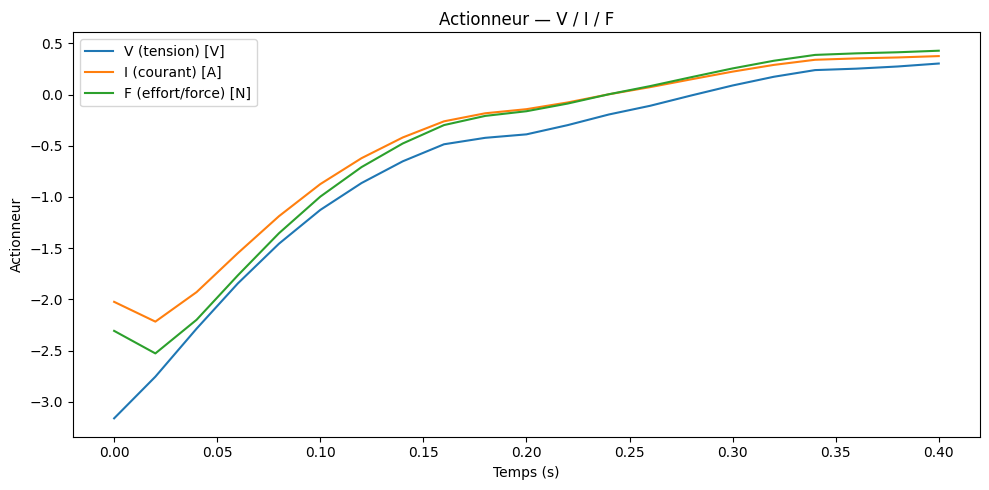

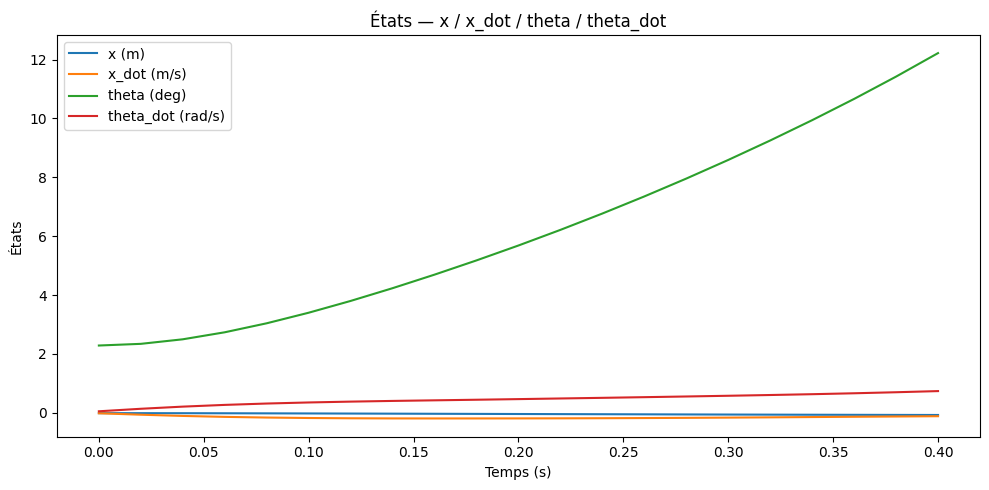

📝 Traces exportées: checkpoints/episode_trace.csv


In [4]:
# ===== Traces V/I/F + états, diagnostic de fin, export CSV =====
import math, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import SAC

MODEL_PATH = found_path  # ou r"sac_logs/best_model.zip"
RENDER = False           # True pour fenêtre CartPole en plus des courbes
MAX_T = 30.0             # durée max (s)

# -- charge modèle si besoin
loaded = SAC.load(MODEL_PATH)

# -- construit l'env (mêmes params que l'entraînement)
try:
    env = make_env(
        render_mode=("human" if RENDER else None),
        Vmax=6.0,
        motor_params=dict(R=1.2, L=0.02, Ke=0.06, Kt=0.06, Imax=8.0, eta=0.95, gear=1.0, r_wheel=0.05),
        friction_params=dict(b_cart=1.5, b_pole=0.01),
        force_limit=60.0,
        seed=2026,
        max_episode_steps=1000,
    )
except NameError:
    raise NameError("make_env n'est pas défini dans ce kernel. Relance le script 'reboot' pour le créer.")

# -- roll-out et enregistrement
obs, info = env.reset()
dt = float(getattr(env.unwrapped, "tau", 0.02))
steps_max = int(MAX_T / dt)

T, Vv, Ii, Ff = [], [], [], []
X, Xd, Th, Thd = [], [], [], []
reason = None

t = 0.0
for k in range(steps_max):
    act, _ = loaded.predict(obs, deterministic=True)
    obs, rew, term, trunc, inf = env.step(act)
    x, xd, th, thd = map(float, obs)

    T.append(t)
    Vv.append(float(inf.get("V", np.nan)))   # tension [V]
    Ii.append(float(inf.get("I", np.nan)))   # courant [A]
    Ff.append(float(inf.get("F", np.nan)))   # effort/force [N]
    X.append(x); Xd.append(xd); Th.append(th); Thd.append(thd)

    t += dt
    if term or trunc:
        th_lim = env.unwrapped.theta_threshold_radians
        x_lim  = env.unwrapped.x_threshold
        if abs(th) >= th_lim:
            reason = f"theta_limit (|θ|={abs(th)*180/math.pi:.1f}° ≥ {th_lim*180/math.pi:.1f}°)"
        elif abs(x) >= x_lim:
            reason = f"x_limit (|x|={abs(x):.3f} m ≥ {x_lim:.3f} m)"
        elif trunc:
            reason = "time_limit"
        break

dur_s = len(T)*dt
print(f"⏱️ Durée épisode: ~{dur_s:.2f} s ({len(T)} pas) | Raison fin: {reason}")

# -- tracés
plt.figure(figsize=(10,5))
plt.plot(T, Vv, label="V (tension) [V]")
plt.plot(T, Ii, label="I (courant) [A]")
plt.plot(T, Ff, label="F (effort/force) [N]")
plt.xlabel("Temps (s)"); plt.ylabel("Actionneur"); plt.title("Actionneur — V / I / F")
plt.legend(); plt.tight_layout(); plt.show(block=False)

plt.figure(figsize=(10,5))
plt.plot(T, X,   label="x (m)")
plt.plot(T, Xd,  label="x_dot (m/s)")
plt.plot(T, np.rad2deg(Th),  label="theta (deg)")
plt.plot(T, Thd, label="theta_dot (rad/s)")
plt.xlabel("Temps (s)"); plt.ylabel("États"); plt.title("États — x / x_dot / theta / theta_dot")
plt.legend(); plt.tight_layout(); plt.show(block=False)

# -- export CSV pour post-analyse
os.makedirs("checkpoints", exist_ok=True)
df = pd.DataFrame({
    "t_s": T, "V_V": Vv, "I_A": Ii, "F_N": Ff,
    "x_m": X, "x_dot_mps": Xd, "theta_deg": np.rad2deg(Th), "theta_dot_rps": Thd
})
csv_path = "checkpoints/episode_trace.csv"
df.to_csv(csv_path, index=False)
print(f"📝 Traces exportées: {csv_path}")
